# Get surface of 3d object

In [1]:
# import library
import math
import random as rng
import os
import cv2 as cv
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import queue
import matplotlib.pyplot as plt

In [2]:
def distancePoint(p1, p2):
    # find distance between 2 points
    a = (p1[0] - p2[0]) * (p1[0] - p2[0])
    b = (p1[1] - p2[1]) * (p1[1] - p2[1])
    return math.sqrt(a + b)


def findSlope(p, q):
    # Find slope and intercept
    if p[1] == q[1]:
        slope = 0
    elif p[0] == q[0]:
        slope = 1e9
    else:
        slope = (q[1] - p[1]) / (q[0] - p[0])
    intercept = p[1] - slope * p[0]
    return slope, intercept

def convert_hull(points):
    count = np.array(points, dtype=np.int32)
    arr = []
    for i in range(count.shape[0]):
        arr.append([count[i][0][0], count[i][0][1]])
    return arr

def convert_shape(points):
    count = np.array(points, dtype=np.int32)
    arr = []
    for i in range(count.shape[0]):
        arr.append([count[i][0][0], count[i][0][1]])
    return arr

def check_shape(src):
    gp_thres = 20
    src = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(src, 100, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    drawing = np.zeros((src.shape[0], src.shape[1], 3), dtype=np.uint8)
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area >= 0.2 * src.shape[0] * src.shape[1]:
            color = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
            cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= 0.2 * src.shape[0] * src.shape[1]:
            # gives area of contour
            perimeter = cv2.arcLength(contour, closed=True)
            borders = cv2.approxPolyDP(curve=contour, epsilon=0.01 * perimeter, closed=False)
            borders = convert_hull(borders)

            temp = borders
            temp.append(borders[0])
            temp.append(borders[1])
            temp.append(borders[2])
            corners_check_shape = []
            arr_same_line = []
            for i in range(len(temp) - 1):

                if i + 2 < len(temp):
                    a = temp[i]
                    b = temp[i + 1]
                    c = temp[i + 2]

                    slope1, _ = findSlope(a, b)
                    slope2, _ = findSlope(b, c)
                    if abs((a[0] * (b[1] - c[1]) + b[0] * (c[1] - a[1]) + c[0] * (a[1] - b[1]))) <= 0.02 * src.shape[
                        0] * src.shape[1]:
                        if len(arr_same_line) > 0:
                            a1 = arr_same_line[0]
                            b1 = temp[i + 1]
                            c1 = temp[i + 2]
                            if abs((a1[0] * (b1[1] - c1[1]) + b1[0] * (c1[1] - a1[1]) + c1[0] * (
                                    a1[1] - b1[1]))) > 0.02 * src.shape[0] * src.shape[1]:
                                corners_check_shape.append(arr_same_line[0])

                                arr_same_line = [temp[i + 1]]
                        else:
                            if temp[i] not in corners_check_shape:
                                arr_same_line.append(temp[i])
                    else:
                        if temp[i] not in arr_same_line:
                            arr_same_line.append(temp[i])
                        if len(arr_same_line) > 0:
                            if arr_same_line[0] not in corners_check_shape:
                                corners_check_shape.append(arr_same_line[0])
                            for k in range(1, len(arr_same_line)):
                                if arr_same_line[k] in corners_check_shape:
                                    corners_check_shape.remove(arr_same_line[k])
                            arr_same_line = []
                        else:
                            if temp[i] not in corners_check_shape:
                                corners_check_shape.append(temp[i])
                else:
                    if len(arr_same_line) > 0:
                        if arr_same_line[0] not in corners_check_shape:
                            corners_check_shape.append(arr_same_line[0])
                        arr_same_line = []
                    else:
                        if temp[i] not in corners_check_shape:
                            corners_check_shape.append(temp[i])
            temp = corners_check_shape
            corners_check_shape = []
            dict_label = {}
            flag = [0] * len(temp)
            for i in range(len(temp)):
                for j in range(i + 1, len(temp)):
                    dis = distancePoint(temp[i], temp[j])
                    if dis <= gp_thres:
                        flag[i] = i + 1
                        flag[j] = i + 1
            for i in range(len(temp)):
                if flag[i] == 0:

                    corners_check_shape.append(temp[i])
                elif flag[i] < 1e9:
                    cnt = 1
                    p = temp[i]

                    for j in range(i + 1, len(temp)):
                        if flag[i] == flag[j]:
                            p[0] += temp[j][0]
                            p[1] += temp[j][1]
                            cnt += 1
                            flag[j] = 1e9
                    p[0] = int(p[0] / cnt)
                    p[1] = int(p[1] / cnt)
                    flag[i] = 1e9
                    corners_check_shape.append(p)
            color = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
            for corner in corners_check_shape:
                cv.circle(drawing, (corner[0], corner[1]), 3, color, -1)
            return corners_check_shape, drawing
    return None


#
# def mainfunc(f):
#     """Old main function"""
#     path = 'dataset/train/'
#     path_seg = 'dataset/segmentation_labels/'
#     name = f.split('.')
#     src_color = cv2.imread(cv2.samples.findFile(path + f))
#     default_file = path_seg + name[0] + '_seg.' + name[1]
#     src = cv2.imread(cv2.samples.findFile(default_file))
#     corners_check_shape, corners = check_shape(src)
#     src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
#     _, src = cv2.threshold(src, 128, 1, cv2.THRESH_BINARY)
#     cropt = cv2.bitwise_and(src_color, src_color, mask=src)
#     src *= 255
#
#
# if __name__ == "__main__":
#     path_main = 'dataset/train/'
#     files = os.listdir(path_main)
#     shape_7 = queue.PriorityQueue()
#     # for f in range(10):
#     #     mainfunc(files[f])
#     with ThreadPoolExecutor() as executor:
#         for f in files:
#             executor.submit(mainfunc, f)




In [99]:
def cv_imread(file_path):
    cv_img = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), 1)
    return cv_img

def find_intersect(slop1, point1, slop2, point2):
    b1 = point1[1] - slop1*point1[0]
    b2 = point2[1] - slop2*point2[0]
    x = (b1 - b2)/(slop2 - slop1)
    y = slop1 * x + b1
    return np.array([int(x), int(y)])

def img_intersect(corners):
    output_size = 640
    # parallel:
    # 1:  0&1 -> 3&4
    # 2:  1&2 -> 4&5
    # 3:  2&3 -> 5&0

    slop_1 = (findSlope(corners[0], corners[1])[0] + findSlope(corners[3], corners[4])[0])/2
    slop_2 = (findSlope(corners[1], corners[2])[0] + findSlope(corners[4], corners[5])[0])/2
    slop_3 = (findSlope(corners[2], corners[3])[0] + findSlope(corners[5], corners[0])[0])/2

    intersect1 = list((find_intersect(slop_1, corners[5], slop_2, corners[3])
                       + find_intersect(slop_1, corners[5], slop_3, corners[1])
                       + find_intersect(slop_2, corners[3], slop_3, corners[1])) / 3)

    intersect2 = list((find_intersect(slop_1, corners[2], slop_2, corners[0])
                       + find_intersect(slop_1, corners[2], slop_3, corners[4])
                       + find_intersect(slop_3, corners[4], slop_2, corners[0])) / 3)
    return (int(intersect1[0]), int(intersect1[1])), (int(intersect2[0]), int(intersect2[1]))

def in_x(w, x, padding_size):
    if x + padding_size > w-1 or x - padding_size < 1:
        return False
    else:
        return True

def in_y(h, y, padding_size):
    if y + padding_size > h-1 or y - padding_size < 1:
        return False
    else:
        return True

def get_region(img, intersect_1, intersect_2, window_size):
    h, w, _ = img.shape
    region_1 = img[(intersect_1[1] - int(window_size/2) if in_x(w, intersect_1[1] - int(window_size/2), window_size/2) else 1) :
                   (intersect_1[1] + int(window_size/2) if in_x(w, intersect_1[1] + int(window_size/2), window_size/2) else w-1), :]
    region_1 = region_1[:, (intersect_1[0] - int(window_size/2) if in_y(h, intersect_1[0] - int(window_size/2), window_size/2) else 1) :
                           (intersect_1[0] + int(window_size/2) if in_y(h, intersect_1[0] + int(window_size/2), window_size/2) else h-1)]

    region_2 = img[(intersect_2[1] - int(window_size/2) if in_x(w, intersect_2[1] - int(window_size/2), window_size/2) else 1) :
                   (intersect_2[1] + int(window_size/2) if in_x(w, intersect_2[1] + int(window_size/2), window_size/2) else w-1), :]
    region_2 = region_2[:, (intersect_2[0] - int(window_size/2) if in_y(h, intersect_2[0] - int(window_size/2), window_size/2) else 1) :
                           (intersect_2[0] + int(window_size/2) if in_y(h, intersect_2[0] + int(window_size/2), window_size/2) else h-1)]

    return region_1, region_2

def get_variance_rgb(img):
    b,g,r = cv2.split(img)
    var_r = np.var(np.array(r).flatten())
    var_g = np.var(np.array(r).flatten())
    var_b = np.var(np.array(r).flatten())
    return np.array([var_r, var_g, var_b])



def cut_img(mask, img, corners):
    window_ratio = 0.03
    _resize = (200,200)
    w, h, _ = img.shape
    output_size = 448

    mask = np.array(mask)


    norm = np.zeros((h,w))
    img = cv.normalize(img,  norm, 0, 255, cv.NORM_MINMAX)

    intersect_1, intersect_2 = img_intersect(corners)

    region_1, region_2 = get_region(img, intersect_1, intersect_2, window_size= int(np.sqrt(window_ratio*w*h)))

    region_1 = cv2.resize(region_1, dsize = _resize)
    region_2 = cv2.resize(region_2, dsize = _resize)

    region_1 = cv2.bilateralFilter(region_1, 9, 75, 75, cv2.BORDER_DEFAULT)
    region_2 = cv2.bilateralFilter(region_2, 9, 75, 75, cv2.BORDER_DEFAULT)



    decision = get_variance_rgb(region_1) > get_variance_rgb(region_2)
    print(get_variance_rgb(region_1), get_variance_rgb(region_2))
    print(decision)
    surface = []
    if sum(decision) >=2:
        #region 1 true
        surface.append([corners[1], corners[0], intersect_1, corners[5]])
        surface.append([corners[2], corners[1], corners[3], intersect_1])
        surface.append([corners[5], corners[4], intersect_1, corners[3]])
    else:
        #region 2 true
        surface.append([corners[1], corners[0], corners[2], intersect_2])
        surface.append([corners[3], corners[2], corners[4], intersect_2])
        surface.append([corners[5], corners[4], corners[0], intersect_2])

    pts = np.float32([[0,0],[output_size,0],[0,output_size],[output_size, output_size]])

    output = [
        cv2.warpPerspective(img,cv2.getPerspectiveTransform(np.array(surface[0]).astype(np.float32),pts),(output_size,output_size)),
        cv2.warpPerspective(img,cv2.getPerspectiveTransform(np.array(surface[1]).astype(np.float32),pts),(output_size,output_size)),
        cv2.warpPerspective(img,cv2.getPerspectiveTransform(np.array(surface[2]).astype(np.float32),pts),(output_size,output_size)),
    ]
    return output

    #return region_1, region_2



In [ ]:
def cut_img6(img, src_img, corners):
    color = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
    output_size = 488

    for i in range(len(corners)-1):
        cv2.line(img, corners[i], corners[i+1], color, 2)

    # parallel:
    # 1:  0&1 -> 3&4
    # 2:  1&2 -> 4&5
    # 3:  2&3 -> 5&0

    slop_1 = (findSlope(corners[0], corners[1])[0] + findSlope(corners[3], corners[4])[0])/2
    slop_2 = (findSlope(corners[1], corners[2])[0] + findSlope(corners[4], corners[5])[0])/2
    slop_3 = (findSlope(corners[2], corners[3])[0] + findSlope(corners[5], corners[0])[0])/2



    intersect1 = list((find_intersect(slop_1, corners[5], slop_2, corners[3])
                       + find_intersect(slop_1, corners[5], slop_3, corners[1])
                       + find_intersect(slop_2, corners[3], slop_3, corners[1])) / 3)
    intersect1[0], intersect1[1] = int(intersect1[0]), int(intersect1[1])

    intersect2 = list((find_intersect(slop_1, corners[2], slop_2, corners[0])
                       + find_intersect(slop_1, corners[2], slop_3, corners[4])
                       + find_intersect(slop_3, corners[4], slop_2, corners[0])) / 3)
    intersect2[0], intersect2[1] = int(intersect2[0]), int(intersect2[1])

    color1 = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
    color2 = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))

    #draw intersect
    cv2.circle(img, (intersect1[0], intersect1[1]), 3, color1, -1)
    cv2.circle(img, (intersect2[0], intersect2[1]), 3, color2, -1)

    #draw lines
    #intersect 1
    cv2.line(img, corners[1], intersect1, color1, 2)
    cv2.line(img, corners[3], intersect1, color1, 2)
    cv2.line(img, corners[5], intersect1, color1, 2)
    #intersect 2
    cv2.line(img, corners[0], intersect2, color2, 2)
    cv2.line(img, corners[2], intersect2, color2, 2)
    cv2.line(img, corners[4], intersect2, color2, 2)

    #get surface 1
    surface_1 = []
    surface_1.append([corners[1], corners[0], intersect1, corners[5]])
    surface_1.append([corners[2], corners[1], corners[3], intersect1])
    surface_1.append([corners[5], corners[4], intersect1, corners[3]])
    #get surface 2
    surface_2 = []
    surface_2.append([corners[1], corners[0], corners[2], intersect2])
    surface_2.append([corners[3], corners[2], corners[4], intersect2])
    surface_2.append([corners[5], corners[4], corners[0], intersect2])

    pts = np.float32([[0,0],[output_size,0],[0,output_size],[output_size, output_size]])

    dst = []
    dst.append(cv2.warpPerspective(src_img,cv2.getPerspectiveTransform(np.array(surface_1[0]).astype(np.float32),pts),(output_size,output_size)))
    dst.append(cv2.warpPerspective(src_img,cv2.getPerspectiveTransform(np.array(surface_1[1]).astype(np.float32),pts),(output_size,output_size)))
    dst.append(cv2.warpPerspective(src_img,cv2.getPerspectiveTransform(np.array(surface_1[2]).astype(np.float32),pts),(output_size,output_size)))

    dst.append(cv2.warpPerspective(src_img,cv2.getPerspectiveTransform(np.array(surface_2[0]).astype(np.float32),pts),(output_size,output_size)))
    dst.append(cv2.warpPerspective(src_img,cv2.getPerspectiveTransform(np.array(surface_2[1]).astype(np.float32),pts),(output_size,output_size)))
    dst.append(cv2.warpPerspective(src_img,cv2.getPerspectiveTransform(np.array(surface_2[2]).astype(np.float32),pts),(output_size,output_size)))


    #choose by detect edge
    # #convert to hsv color
    # hsv_dst = []
    # len_line = []
    # for i in dst:
    #     #resize
    #     i = cv2.resize(i, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
    #     crop_size = 10
    #     i = i[crop_size:-crop_size, crop_size:-crop_size]
    #
    #     # blur
    #     i = cv2.bilateralFilter(i, 9, 75, 75, cv2.BORDER_DEFAULT)
    #
    #     # hsv color
    #     hsv_image = cv2.cvtColor(i, cv2.COLOR_BGR2HSV)
    #     h, s, v = cv2.split(hsv_image)
    #
    #     # Apply edge detection method on the image
    #     edges = cv2.Canny(v, 100, 150)
    #     lines = cv2.HoughLines(edges, 1, np.pi/180, 50)
    #     if lines is None:
    #         len_line.append(0)
    #     else:
    #         len_line.append(len(lines))
    #     hsv_dst.append(edges)
    #
    # print(len_line)
    # # if np.sum(len_line[0:3]) < np.sum(len_line[3:]):
    # #     return dst[0:3]
    # # else:
    # #     return dst[3:]

    #choose by detect corners
    resize_img = cv2.resize(src_img, dsize = (100,100))
    # hsv color
    hsv_image = cv2.cvtColor(resize_img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)

    resize_img = cv2.bilateralFilter(v, 9, 75, 75, cv2.BORDER_DEFAULT)
    #resize_img = cv2.GaussianBlur(resize_img, (3,3), 0)
    window = 8
    h, w, _ = src_img.shape
    ratio_h, ratio_w = h/100, w/100

    h_l_1 = int(intersect1[1]/ratio_h)-window if int(intersect1[1]/ratio_h)-window > 0 else 5
    h_h_1 = int(intersect1[1]/ratio_h)+window if int(intersect1[1]/ratio_h)+window < 95 else 95
    w_l_1 = int(intersect1[0]/ratio_w)-window if int(intersect1[0]/ratio_w)-window > 0 else 5
    w_h_1 = int(intersect1[0]/ratio_w)+window if int(intersect1[0]/ratio_w)+window < 95 else 95
    region1 = resize_img[h_l_1:h_h_1, w_l_1:w_h_1]

    h_l_2 = int(intersect2[1]/ratio_h)-window if int(intersect2[1]/ratio_h)-window > 0 else 5
    h_h_2 = int(intersect2[1]/ratio_h)+window if int(intersect2[1]/ratio_h)+window < 95 else 95
    w_l_2 = int(intersect2[0]/ratio_w)-window if int(intersect2[0]/ratio_w)-window > 0 else 5
    w_h_2 = int(intersect2[0]/ratio_w)+window if int(intersect2[0]/ratio_w)+window < 95 else 95
    region2 = resize_img[h_l_2:h_h_2, w_l_2:w_h_2]

    var_1 = np.var(np.array(region1).flatten())
    var_2 = np.var(np.array(region2).flatten())

    # kernel = np.ones((5, 5), np.uint8)
    # dilation_1 = cv2.dilate(region1, kernel, iterations=1)
    # dilation_2 = cv2.dilate(region2, kernel, iterations=1)
    #
    # dilation_1 = cv2.GaussianBlur(dilation_1, (5,5), 0)
    # dilation_2 = cv2.GaussianBlur(dilation_2, (5,5), 0)
    #
    # edges_1 = cv2.Canny(dilation_1, 50, 150)
    # edges_2 = cv2.Canny(dilation_2, 50, 150)
    #
    #
    # if sum(np.array(edges_1).flatten()) > sum(np.array(edges_2).flatten()):
    #     return dst[0:3]
    # else:
    #     return dst[3:]

    # print(var_1, var_2)
    if var_1 > var_2:
        return dst[0:3]
    else:
        return dst[3:]

    #return edges_1, edges_2


(210, 204, 3)
[[69, 4], [0, 121], [47, 204], [144, 208], [202, 93], [166, 4]]
[215.53005945 215.53005945 215.53005945] [1070.863434 1070.863434 1070.863434]
[False False False]
choose region 2


<Figure size 640x480 with 0 Axes>

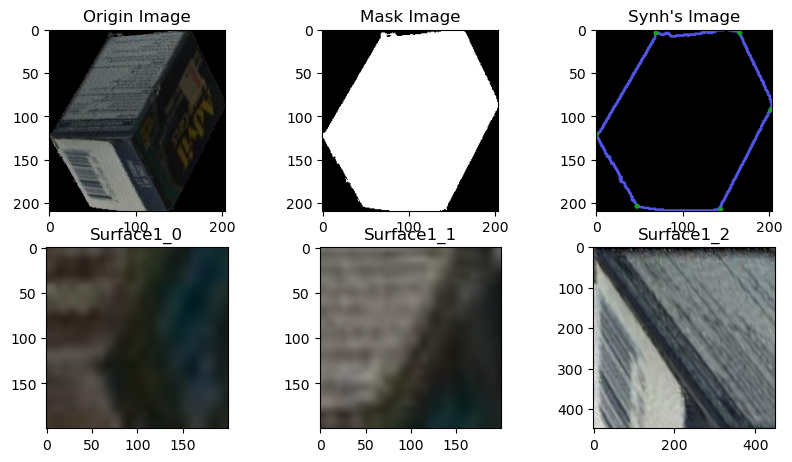

In [95]:
img_name = '00001_581.jpg'
src_img = cv2.imread('classify/box/seg/'+img_name)
img = cv2.imread('classify/box/label/'+img_name)
plt.set_cmap("gray")

plt.figure(figsize = [10, 8])
plt.subplot(331); plt.imshow(src_img[:,:,::-1]); plt.title('Origin Image')
plt.subplot(332); plt.imshow(img[:,:,::-1]); plt.title('Mask Image')

print(img.shape)
corners = check_shape(img)
print(corners[0])
plt.subplot(333); plt.imshow(corners[1][:,:,    ::-1]); plt.title("Synh's Image")

if len(corners[0]) == 6:
    cut = cut_img(img, src_img, corners[0])
    plt.subplot(334); plt.imshow(cut[0][:,:]); plt.title('Surface1_0')
    plt.subplot(335); plt.imshow(cut[1][:,:]); plt.title('Surface1_1')
    plt.subplot(336); plt.imshow(cut[2][:,:, ::-1]); plt.title('Surface1_2')
    # plt.subplot(337); plt.imshow(cut[3][:,:, ::-1]); plt.title('Surface2_0')
    # plt.subplot(338); plt.imshow(cut[4][:,:, ::-1]); plt.title('Surface2_1')
    # plt.subplot(339); plt.imshow(cut[5][:,:, ::-1]); plt.title('Surface2_2')


In [100]:
import pygame
import os
import cv2

pygame.init()

# creating display
X = 244*3
Y = 244*2

# create the display surface object
# of specific dimension..e(X, Y).
scrn = pygame.display.set_mode((X, Y))

# set the pygame window name
pygame.display.set_caption('image')

img_index = 0
img_pos = 1
status = True
output_path = 'classify/box/crop/'

while status:
    file = os.listdir('classify/box/seg/')[img_index]
    src_img = cv_imread('classify/box/seg/'+file)
    img = cv_imread('classify/box/label/'+file)
    corners = check_shape(img)
    plt.set_cmap("gray")

    if len(corners[0]) == 6:
        cut = cut_img(img, src_img, corners[0])
        # concatenate image Horizontally

        hori_1 = np.concatenate([cv2.resize(src_img, dsize = (244,244)), cv2.resize(img, dsize = (244,244)), cv2.resize(corners[1], dsize = (244,244))], axis=0)
        hori_2 = np.concatenate([cv2.resize(cut[0], dsize = (244,244)), cv2.resize(cut[1], dsize = (244,244)), cv2.resize(cut[2], dsize = (244,244))], axis = 0)

        output = np.concatenate([hori_1, hori_2], axis= 1)[:,:,::-1]

        surf = pygame.surfarray.make_surface(output)
        scrn.blit(surf, (0, 0))
        pygame.display.flip()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                status = False

            # checking if keydown event happened or not
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RIGHT:
                    img_index+=1
                    print(file)
                if event.key == pygame.K_LEFT:
                    print()

    else:
        img_index+=1


pygame.quit()

[1874.01279792 1874.01279792 1874.01279792] [5321.56294545 5321.56294545 5321.56294545]
[False False False]
[1874.01279792 1874.01279792 1874.01279792] [5321.56294545 5321.56294545 5321.56294545]
[False False False]
[1874.01279792 1874.01279792 1874.01279792] [5321.56294545 5321.56294545 5321.56294545]
[False False False]
[1874.01279792 1874.01279792 1874.01279792] [5321.56294545 5321.56294545 5321.56294545]
[False False False]
[1874.01279792 1874.01279792 1874.01279792] [5321.56294545 5321.56294545 5321.56294545]
[False False False]
[1874.01279792 1874.01279792 1874.01279792] [5321.56294545 5321.56294545 5321.56294545]
[False False False]
[1874.01279792 1874.01279792 1874.01279792] [5321.56294545 5321.56294545 5321.56294545]
[False False False]
[1874.01279792 1874.01279792 1874.01279792] [5321.56294545 5321.56294545 5321.56294545]
[False False False]
[1874.01279792 1874.01279792 1874.01279792] [5321.56294545 5321.56294545 5321.56294545]
[False False False]
[1874.01279792 1874.01279792

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>